In [1]:
import sys
sys.path.insert(0, '/global/homes/z/zhzhuoqi/.local/cori/3.7-anaconda-2019.10/lib/python3.7/site-packages/TreeCorr-4.1-py3.7-linux-x86_64.egg')

In [2]:
import treecorr
treecorr.__version__

'4.1'

In [3]:
import GCRCatalogs
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import healpy as hp
import camb
import camb.correlations
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show, colorbar

In [4]:
def get_healpixel_footprint(ra, dec, nside, nest=False, count_threshold=None):
    pixels = hp.ang2pix(nside, ra, dec, nest=nest, lonlat=True)
    if count_threshold and count_threshold > 1:
        pixels, counts = np.unique(pixels, return_counts=True)
        return pixels[counts >= count_threshold]
    return np.unique(pixels)

In [5]:
def generate_uniform_random_ra_dec_healpixel(n, pix, nside, nest=False):

    ra, dec = hp.vec2ang(hp.boundaries(nside, pix, 1, nest=nest).T, lonlat=True)
    ra_dec_min_max = ra.min(), ra.max(), dec.min(), dec.max()

    ra = np.empty(n)
    dec = np.empty_like(ra)
    n_needed = n

    while n_needed > 0:
        ra_this, dec_this = generate_uniform_random_ra_dec_min_max(n_needed*2, *ra_dec_min_max)
        mask = np.where(hp.ang2pix(nside, ra_this, dec_this, nest=nest, lonlat=True) == pix)[0]
        count_this = mask.size
        if n_needed - count_this < 0:
            count_this = n_needed
            mask = mask[:n_needed]

        s = slice(-n_needed, -n_needed+count_this if -n_needed+count_this < 0 else None)
        ra[s] = ra_this[mask]
        dec[s] = dec_this[mask]
        n_needed -= count_this

    return ra, dec

def generate_uniform_random_ra_dec_min_max(n, ra_min, ra_max, dec_min, dec_max):

    ra = np.random.uniform(ra_min, ra_max, size=n)
    dec = np.random.uniform(np.sin(np.deg2rad(dec_min)), np.sin(np.deg2rad(dec_max)), size=n)
    dec = np.arcsin(dec, out=dec)
    dec = np.rad2deg(dec, out=dec)
    return ra, dec

In [6]:
def generate_uniform_random_ra_dec_footprint(n, footprint=None, nside=None, nest=False):

    if footprint is None or hp.nside2npix(nside) == len(footprint):
        return generate_uniform_random_ra_dec(n)

    n_per_pix_all = np.histogram(np.random.rand(n), np.linspace(0, 1, len(footprint)+1))[0]

    ra = np.empty(n)
    dec = np.empty_like(ra)
    count = 0

    for n_per_pix, pix in zip(n_per_pix_all, footprint):
        ra_this, dec_this = generate_uniform_random_ra_dec_healpixel(n_per_pix, pix, nside, nest)
        s = slice(count, count+n_per_pix)
        ra[s] = ra_this
        dec[s] = dec_this
        count += n_per_pix

    assert count == n

    return ra, dec


In [7]:
def theory_real_cross(lmax2, z_vals, n_vals, xvals):
    ''' Compute the correlation between galaxy shear and CMB lensing in real space '''
    ns = 0.963
    s8 = .8

    Omega_c = .22
    Omega_b = .0045
    h = 71./100.

    cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, sigma8 = s8, n_s = ns)#, transfer_function='boltzmann_class', matter_power_spectrum='emu')
    cmbl1 = ccl.CMBLensingTracer(cosmo_ccl, 1100) # second number is source redshift
    lens1 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(z_vals, n_vals))
    ll = np.arange(lmax2)

    num = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(z_vals, n_vals), bias = (z_vals,np.ones(len(z_vals))*1.3))
    #cls = ccl.angular_cl(cosmo_ccl, cmbl1, cmbl1, ll)
    cls = ccl.angular_cl(cosmo_ccl, lens1, cmbl1, ll) #k
    cls_num = ccl.angular_cl(cosmo_ccl,num,cmbl1,ll) #nk
    win = hp.pixwin(4096)[:lmax2]
    cls = cls*win**2
    pp3_2 = np.zeros((lmax2, 4))
    pp3_2[:, 0] = cls[:] * (ll * (ll + 1.)) / (2. * np.pi)
    cxvals = np.cos(xvals / (60.) / (180. / np.pi))
    vals = camb.correlations.cl2corr(pp3_2, cxvals)#from fourier space to real space
    #cls_num = cls_num*win**2
    pp3_2 = np.zeros((lmax2, 4))
    pp3_2[:, 0] = cls_num[:] * (ll * (ll + 1.)) / (2. * np.pi)
    cxvals = np.cos(xvals / (60.) / (180. / np.pi))
    vals2 = camb.correlations.cl2corr(pp3_2, cxvals)
    return xvals, vals[:, 0], vals2[:, 0]

In [8]:
filename = '/global/projecta/projectdirs/lsst/groups/CS/cosmoDC2/mass_sheets_behind_z3/cmb_maps/cmblensmap_total_gausshiz_masked.fits'

In [9]:
mapfile = hp.read_map(filename)
print(len(mapfile))

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1/envs/desc/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
201326592


In [10]:
index = np.arange(201326592)
theta, phi = hp.pix2ang(nside=4096, ipix=index)

In [11]:
gc = GCRCatalogs.load_catalog('cosmoDC2')

In [12]:
data = gc.get_quantities(['ra', 'dec', 'redshift', 'mag_i_lsst'], filters=['mag_i_lsst<22'])

In [13]:
redshift_mask = (data['redshift']<0.6)*(data['redshift']>0.5)

In [14]:
#cut out the CosmoDC2 region from KCMB
nside = 512
healpix_id = get_healpixel_footprint(data['ra'][redshift_mask], data['dec'][redshift_mask], nside) 
print(healpix_id)
npix = hp.nside2npix(nside)
m = np.zeros(npix)
m[healpix_id]=1
new = hp.ud_grade(m, 4096)
cmb_mask = new>0
ra_K = np.degrees(phi[cmb_mask])
dec_K = np.degrees(np.pi/2-theta[cmb_mask])
kcmb = mapfile[cmb_mask]

[2227504 2227519 2227520 ... 2714559 2714575 2714591]


In [34]:
cat_N = treecorr.Catalog(ra=data['ra'][redshift_mask], dec=data['dec'][redshift_mask], ra_units='deg', dec_units='deg', npatch=40)
Npatch = cat_N.patch
Npatch_center = cat_N.get_patch_centers()

In [35]:
cat_K = treecorr.Catalog(ra=ra_K, dec=dec_K, k=kcmb, ra_units='deg', dec_units='deg', patch_centers=Npatch_center)
Kpatch=cat_K.patch

In [36]:
#generate random ra and dec
n = 10*len(data['ra'][redshift_mask])
nside = 512
ra_random, dec_random = generate_uniform_random_ra_dec_footprint(n, footprint=healpix_id, nside=nside, nest=False)

In [37]:
cat_N_random = treecorr.Catalog(ra=ra_random, dec=dec_random, ra_units='deg', dec_units='deg', patch_centers=Npatch_center)
Rpatch=cat_N_random.patch

In [38]:
nk = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180))

In [39]:
nk_rand = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180))

Brute-force jackknife on NK with random subtraction

In [49]:
results = []
for i in range(1, 40):
    #remove patch
    Kpatch_mask = np.invert((Kpatch==i))
    Npatch_mask = np.invert((Npatch==i))
    Rpatch_mask = np.invert((Rpatch==i))
    #do the nk
    cat_N_jackknife = treecorr.Catalog(ra=data['ra'][redshift_mask][Npatch_mask], dec=data['dec'][redshift_mask][Npatch_mask], ra_units='deg', dec_units='deg')
    cat_K_jackknife = treecorr.Catalog(ra=ra_K[Kpatch_mask], dec=dec_K[Kpatch_mask], k=kcmb[Kpatch_mask], ra_units='deg', dec_units='deg')
    cat_R_jackknife = treecorr.Catalog(ra=ra_random[Rpatch_mask], dec=dec_random[Rpatch_mask], ra_units='deg', dec_units='deg')
    nk.process(cat_N_jackknife, cat_K_jackknife)
    nk_rand.process(cat_R_jackknife, cat_K_jackknife)
    R = np.exp(nk.logr)
    xi = np.ndarray.tolist(nk.xi-nk_rand.xi)
    results.append(xi)

In [50]:
results = np.array(results)

In [51]:
stats = np.transpose(results)

In [52]:
cov = np.zeros((len(stats), len(stats)))
for r in range(0, len(stats)):
    for s in range(0, len(stats)):
        cov[r][s] = (len(results)-1)*np.average((stats[r]-np.average(stats[r]))*(stats[s]-np.average(stats[s])))

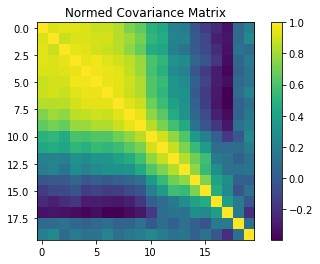

In [53]:
norm_cov = cov.copy()
for i in range(len(cov)):
    for j in range(len(cov)):
        norm_cov[i][j]/=np.sqrt(cov[i][i]*cov[j][j])
plt.imshow(norm_cov)
plt.title('Normed Covariance Matrix')
plt.colorbar()
#plt.savefig('cov_jackknife.png',dpi=200)

Text(0.5, 0, 'ang. sep. [arcmin]')

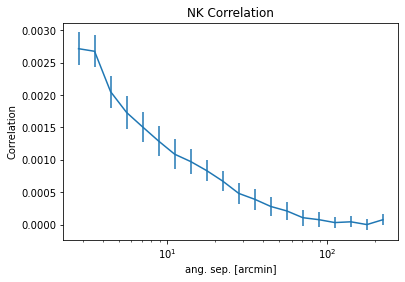

In [54]:
plt.errorbar(60*np.degrees(R), np.average(results,axis=0), yerr=np.sqrt(np.diag(cov)))
plt.xscale('log')
plt.title('NK Correlation')
plt.ylabel('Correlation')
plt.xlabel('ang. sep. [arcmin]')
#plt.savefig('NK_jackknife.png',dpi=200)

Jackknife on NK in treecorr, with random subtraction

In [30]:
nk_rand = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180), var_method='jackknife')

In [40]:
nk_rand.process(cat_N_random, cat_K)

In [32]:
nk_jk = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180), var_method='jackknife')

In [45]:
nk_jk.process(cat_N, cat_K)
nk_jk.calculateXi(rk=nk_rand)

(array([2.70688140e-03, 2.67183616e-03, 2.06009632e-03, 1.71838936e-03,
        1.50575933e-03, 1.29971106e-03, 1.07963370e-03, 9.71255451e-04,
        8.28907117e-04, 6.68707999e-04, 4.80564589e-04, 3.93389615e-04,
        2.77435801e-04, 2.08182355e-04, 1.00093558e-04, 8.25008082e-05,
        2.43415826e-05, 4.11282523e-05, 8.44809719e-06, 7.26110193e-05]),
 array([1.50376791e-06, 1.50219800e-06, 1.50583270e-06, 1.50435255e-06,
        1.50371012e-06, 1.51709348e-06, 1.53443791e-06, 1.56773982e-06,
        1.57810784e-06, 1.60529112e-06, 1.63077378e-06, 1.66740195e-06,
        1.67778136e-06, 1.70007920e-06, 1.75324320e-06, 1.82341323e-06,
        1.86944457e-06, 1.98316306e-06, 2.08426867e-06, 2.20729170e-06]))

In [46]:
xi_nk = nk_jk.xi
R_nk = np.exp(nk_jk.logr)
varxi_nk = nk_jk.varxi

Text(0.5, 0.98, 'NK Correlation Random')

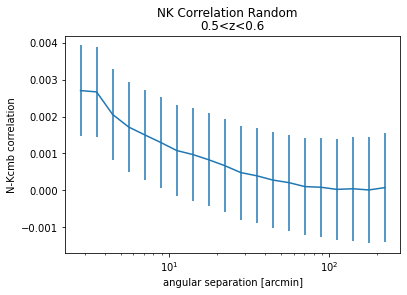

In [47]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.errorbar(np.degrees(R_nk)*60, xi_nk, yerr=np.sqrt(varxi_nk))
ax.set_title('0.5<z<0.6')
ax.set_xlabel('angular separation [arcmin]')
ax.set_ylabel('N-Kcmb correlation')
fig.suptitle('NK Correlation Random')
#fig.savefig('NK_corrected(1).png',dpi=200)

Comparing the results

In [48]:
'''
plt.errorbar(60*np.degrees(R), xi_nk, yerr=np.sqrt(varxi_nk),label='treecorr')
plt.errorbar(60*np.degrees(R), np.average(results,axis=0), yerr=np.sqrt(np.diag(cov)), color='red', label='brute force')
plt.xscale('log')
plt.title('NK Correlation')
plt.ylabel('Correlation')
plt.xlabel('ang. sep. [arcmin]')
plt.legend()'''
#plt.savefig('NK_jackknife.png',dpi=200)

"\nplt.errorbar(60*np.degrees(R), xi_nk, yerr=np.sqrt(varxi_nk),label='treecorr')\nplt.errorbar(60*np.degrees(R), np.average(results,axis=0), yerr=np.sqrt(np.diag(cov)), color='red', label='brute force')\nplt.xscale('log')\nplt.title('NK Correlation')\nplt.ylabel('Correlation')\nplt.xlabel('ang. sep. [arcmin]')\nplt.legend()"